# Study of mixing time for a small world network and lazy random walk

## What I've done

1) I completely analyzed the lazy random walk for a small world network with L=[2, ... , 10] and r=2. I made a database in order to compute the mixing time which turns out to scale as $O(\log(n)^3)$


## What remains to do

1) optimize the algorithm with a clever choice of max_walks and max_steps.

2) is there a clever way to store path at different starting point?

### I start here with the main definition of functions

In [69]:
import networkx as nx
import numpy as np
from multiprocess import Pool, cpu_count
from ipywidgets import interact, fixed
from tqdm.notebook import trange, tqdm
%matplotlib inline
import matplotlib.pyplot as plt
import math
import pickle
import pprint

from time import time

np.random.seed(42)

##################
# Random walks
##################

def simple_2d_random_walk_parallel(G, L, max_steps, start_node=(0,0), use_random_starting_node=False, seed=42):
    np.random.seed(seed)
    '''
    Returns a list of edges visited in a simple random path
    
    Arguments:
    - G: Graph
    - L: number of points on line
    - max_steps: number of steps considered in the path
    - use_random_starting_node: if True the starting node is random
    - seed: inital number used to generate the random path
    
    Return:
    - path: list of edges 
        - path[0] first edges
        - path[i][1] (i+1)-th nodes visited
    '''
    if use_random_starting_node:
        current_node = tuple(np.random.randint(0, L, 2))
    else:
        current_node = start_node
        
    path=[]
    # for-loop over max_steps
    for t in range(max_steps):
        # randomly choose from neighbors of current node
        new_node = tuple(list(G.neighbors(current_node))[np.random.randint(0, nx.degree(G, current_node))])
        # append new node to path
        path.append((current_node, new_node))
        current_node = new_node
        
    return path


def lazy_2d_random_walk_parallel(G, L, max_steps, start_node=(0,0), use_random_starting_node=False, seed=42):
    '''
    Returns a list of edges visited in a lazy random path
    
    Arguments:
    - G: Graph
    - L: number of points on line
    - max_steps: number of steps considered in the path
    - use_random_starting_node: if True the starting node is random
    - seed: inital number used to generate the random path
    
    Return:
    - path: list of edges 
        - path[0] first edges
        - path[i][1] (i+1)-th nodes visited
    '''
    np.random.seed(seed)
    if use_random_starting_node:
        current_node = tuple(np.random.randint(0, L, 2))
    else:
        current_node = start_node
        
    path=[]
    # for-loop over max_steps
    for t in range(max_steps):
        # stay at current node with p=1/2 or move to a neighboring 
        # node with each p=1/2d_n (d_n degree of current node)
        new_node = current_node if np.random.uniform(0,1) <= 0.5 else tuple(list(G.neighbors(current_node))[np.random.randint(0, nx.degree(G, current_node))])
        # append new node to path
        path.append((current_node, new_node))
        current_node = new_node
    return path

##################
#DISTANCE
##################

def dist_1d(a, b, L):
    '''
    Distance between two points on a periodic 
    line with length L.
    
    Arguments:
    - a: first point (integer 0,..,L-1)
    - b: second point (integer 0,...,L-1)
    - L: number of points on line
    
    Return:
    - d: distance between points
    '''
    # handle usage of bad arguments
    if a>=L or b>=L or a<0 or b<0:
        print('INFO: \na={} or b={} should be in range [0,L-1]=[0,{}]. Using a%L={} or b%L={} instead.\n'.format(a, b, L, a%L, b%L))
        a = a%L
        b = b%L
    if type(a) != int or type(b) != int or type(L) != int:
        print('INFO: \nAll arguments should be type int. You used type(a)={}, type(b)={}, type(L)={}. \nWill be converted using int(..).\n'.format(type(a), type(b), type(L)))
        a, b, L = int(a), int(b), int(L)
        
    # return distance
    d = 0
    if abs(a-b)<L/2.:
        d = abs(a-b)
    else :
        d = L-abs(a-b)
    return d


def dist_2d_lattice(u, v, L):
    '''
    Distance between two node on a periodic 
    lattice graph with side length L.
    
    Arguments:
    - u: first node (tuple (u_0, u_1))
    - v: second node (tuple (v_0, v_1))
    - L: side length of lattice
    
    Return:
    - d: distance between points (-1 if error occured)
    '''
    # handle arguments having wrong types
    if type(u)!=tuple or type(v)!= tuple:
        print('ERROR: \nArguments u and v should be type tuple. You used type(u)={}, type(v)={}. \nBreak and return -1\n'.format(type(u), type(v)))
        return -1
    if type(L)!=int:
        print('INFO: \nArgument L should be type int. You used type(L)={}. Now using int(L)={}\n'.format(type(L), int(L)))
        L=int(L)
    
    d = dist_1d(u[0], v[0], L) + dist_1d(u[1], v[1], L)
    return d

##################
#MODEL
##################
def Kleinberg_2d(L,r, seed=42):
    '''
    constructor of a Kleinber graph model
    
    Arguments:
    - L: number of points on line
    - r: parameter for the long range decay
    - seed: inital number used to generate the random edges
    
    Return:
    - G: Kleinber graph
    '''
    np.random.seed(42)
    G = nx.grid_2d_graph(L,L, periodic=True)
    Z=0
    # computation of Z from (0,0) node
    for y in G:
        if y!=(0,0):
            Z=Z+dist_2d_lattice((0,0),y,L)**(-r)
    # creation of new long range random edges
    for x in G:
        for y in G:
            if x>y: #to avoid self loop and also double count on the edges
                if np.random.uniform(0, 1)<(dist_2d_lattice(x,y,L)**(-r)/Z):
                    G.add_edge(x,y) 
    return G

def small_world_2d(L,r, seed=42):
    '''
    constructor of a Small world graph model
    
    Arguments:
    - L: number of points on line
    - r: parameter for the long range decay
    - seed: inital number used to generate the random edges
    
    Return:
    - G: Kleinber graph
    '''
    np.random.seed(42)
    G = nx.grid_2d_graph(L,L, periodic=True)
    Z=0
    # computation of Z from (0,0) node
    for y in G:
        if y!=(0,0):
            d=dist_2d_lattice((0,0),y,L)
            # Z is computed ONLY over the long range distance
            if d>1:
                Z=Z+d**(-r) 
    # creation of new long range random edges
    for x in G:
        for y in G:
            if x>y: #to avoid self loop and also double count on the edges
                if np.random.uniform(0, 1)<(dist_2d_lattice(x,y,L)**(-r)/Z):
                    G.add_edge(x,y) 
    return G

################
#ANALYSIS
################
    '''
    These two function are a little different than yours, I took for granted the parallel algorithm part
    '''

def get_path_forG(G, L, r=2, max_steps=int(1e2), max_walks=int(1e3),  start_node=(0,0), use_random_starting_node=False,
             random_walk_function=simple_2d_random_walk_parallel):
    '''
    Given a Graph G and a type of random walk, it returns a list containing the nodes visited
    for a random path of time max_steps for each max_walks random path
    
    Arguments:
    - G: graph
    - L: number of nodes on line
    - r: parameter for the long range decay
    - max_steps: time of the random path
    - max_walks: number of random path (walk) considered
    - start_node: initial node
    - use_random_starting_node: if True the starting node is random
    - random_walk_function: simple_2d_random_walk_parallel for default
    
    Return:
    - np.array(paths):
        - paths[i]: list of visited nodes for the i-th walk
    '''
    # seed list
    seed_list = np.random.permutation(np.arange(0, max_walks)).tolist()

    # list of random walks (dim = (max_walks, max_steps))
    pool = Pool(cpu_count())
    paths = np.array(pool.starmap_async(random_walk_function, [(G, L, max_steps, start_node, use_random_starting_node, seed) for seed in seed_list]).get())[:,:,1]
    pool.close()
    
    return np.array(paths)

def get_L1_norm_over_step_count(G, L, paths, max_steps=int(1e2), max_walks=int(1e3), regular_graph=True):
    '''
    It returns the total variance with the stationary distribution. it is computed as a statistical inference
    over a max_walks number of path and it is plotted against the time (steps)
    
    Arguments:
    - G: graph
    - L: number of nodes on line
    - max_steps: time of the random path
    - max_walks: number of random path (walk) considered
    - regular_graph: if True the graph has the same degree at each nodes
    
    Return:
    - np.array(norm_vector): array containing the total variance over time index
        - norm_vector[i]: total variance at i-th time (step) computed with statistical inference with 
                          max_walks random paths.
    '''
    # compute L1 norm for every random walk step
    norm_vector=[]
    for num_steps in range(max_steps):
        prob, _ = np.histogram(a=paths[:max_walks,num_steps,0]*L + paths[:max_walks,num_steps,1], bins=np.arange(0,L*L+1), density=True)
        # L1 norm using node distribution from random walks and stationary distriubtion
        # pi_v = d_v/(2*E), with d_v the degree of vertex/node v. For the periodic
        # lattice d_v=4 and hence pi_v = 1/ #nodes_in_G = 1/L*L
        if regular_graph:
            norm_vector.append(0.5 * np.sum(abs(prob - np.ones(prob.shape[0])/(L*L))))
        
        # If the graph is not regular (e.g. small world) the stationary distribution is not uniform
        else:
            #definition of stationary probability vector
            list_degree=[]
            for v in G:
                list_degree.append(nx.degree(G,v))
            degree=np.array(list_degree)
            norm_vector.append(0.5 * np.sum(abs(prob - degree/(2*nx.number_of_edges(G)))))
    
    return np.array(norm_vector)

#################
#Plot function
#################

def plot_walk(G, L, total_path, steps=-1, figure_size=(10,10)):
    # take only specified steps of path (-1 -> complete path)
    path = total_path[:steps]
    # color map
    color_map=[]
    for node in G:
        if node == path[0][0]:
            color_map.append('red') #INITIAL POINT RED
        elif node == path[-1][1]: 
            color_map.append('blue') #END POINT BLUE
        else:
            color_map.append('lightgreen')

    # FIGURE
    plt.figure(figsize=figure_size)
    # make graph R to display the path
    R = nx.grid_2d_graph(L,L,periodic=True)
    R.remove_edges_from(list(R.edges))
    R.add_edges_from(path)
    pos = {(x,y):(y,-x) for x,y in G.nodes()}
    
    # draw underlying network
    nx.draw(G, pos=pos, node_color='lightgreen', edge_color='lightgray',
        with_labels=False, node_size=100, width=3)
    # draw path using R
    nx.draw(R, pos=pos, node_color=color_map, with_labels=False,
        node_size=100, edge_color='red', width=2)
    plt.show()

# Creation of a database

This code create a database for a small_world graph with r=2 of lazy random paths at any different starting_node. In order to run this code you need to have in your main folder these empty folders:

**Small_world_L=2_r=2**

**Small_world_L=3_r=2**

**Small_world_L=4_r=2** and so on up to L=10

This code will save in pkl format the graph (we need also to save the graph if we want to use this data after, since the paths are strictly related to the type of random graph) and the random path in this form

**L=2_small_world_steps(200)_walks(10e3)_starting=(0, 0).pkl**

**L=2_small_world_steps(200)_walks(10e3)_starting=(0, 1).pkl**

**L=2_small_world_steps(200)_walks(10e3)_starting=(1, 0).pkl**

**L=2_small_world_steps(200)_walks(10e3)_starting=(1, 1).pkl** and so on

### This code takes 2 h. to run and it is about 12Gb !!!

(If you want you can run this code by choosing max_walks=2000 and max_steps=25, for higher parameters the data will be high redundancy (see later) )

In [23]:
# here we can decide the number of step, walks and the parameter r
max_steps=200 
max_walks=int(10e3)
r=2

for L in range(2,3): #L=[2,3,...,10]
    G=small_world_2d(L,r)
    output = open('Small_world_L={}_r={}/graph.pkl'.format(L,r), 'wb')
    pickle.dump(G, output)
    output.close()
    # different starting node
    for v in G:
        tic = time()
        all_paths=get_path_forG(G, L, r=r, max_steps=max_steps, max_walks=max_walks, start_node=v,
                                random_walk_function=lazy_2d_random_walk_parallel)
        toc = time()
        time_L = toc-tic
        print(toc-tic)
        output = open('Small_world_L={}_r={}/L={}_small_world_steps({})_walks({})_starting={}.pkl'.format(L,r,L,max_steps,max_walks,v), 'wb')
        pickle.dump(all_paths, output)
        output.close()

18.400293111801147
19.01464009284973


Process ForkPoolWorker-1552:
Process ForkPoolWorker-1549:
Process ForkPoolWorker-1550:
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-1551:
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/multiprocess/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/multiprocess/proc

## Plot the total variance for different inference parameter max_walks

### For L=2

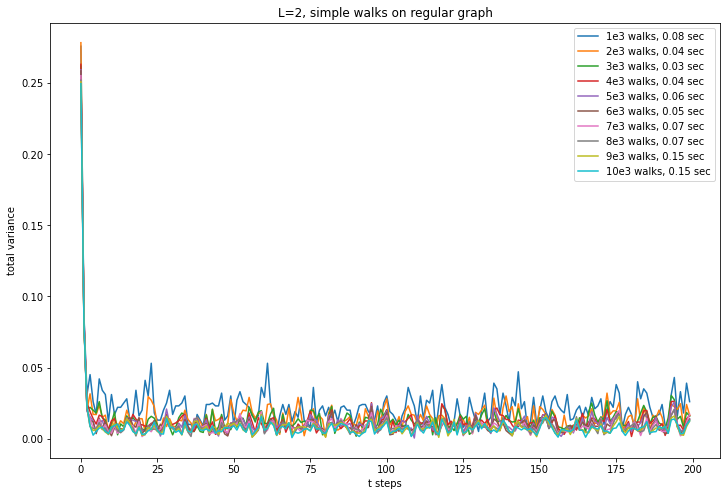

In [8]:
# here we choose the file with L,r, starting node, max_step and max_walks
L=2
r=2
starting=(1,0)
max_steps=200
max_walks=int(10e3)

#uploading the graph
pkl_file = open('Small_world_L={}_r={}/graph.pkl'.format(L,r), 'rb')
G = pickle.load(pkl_file)

#uploading the data
pkl_file = open('Small_world_L={}_r={}/L={}_small_world_steps({})_walks({})_starting={}.pkl'.format(L,r,L,max_steps,max_walks,starting), 'rb')
data = pickle.load(pkl_file)
norm_vector_list_parallel = []
for i in tqdm([1,2,3,4,5,6,7,8,9,10]):
    tic = time()
    norm_vector = get_L1_norm_over_step_count(G, L, data, max_steps=max_steps, max_walks=int(i*1e3))
    toc = time()
    time_i = toc-tic
    norm_vector_list_parallel.append((i, time_i, norm_vector))
# Plot
fig1, ax1 = plt.subplots(figsize=(12,8))
for i, time_i, norm_vector in norm_vector_list_parallel:
    ax1.plot(norm_vector, label="{}e3 walks, {:.2f} sec".format(i, time_i))

ax1.set_title('L={}, simple walks on regular graph'.format(L))
ax1.set_xlabel('t steps')
ax1.set_ylabel('total variance')
ax1.legend()
plt.show()

### For L=10

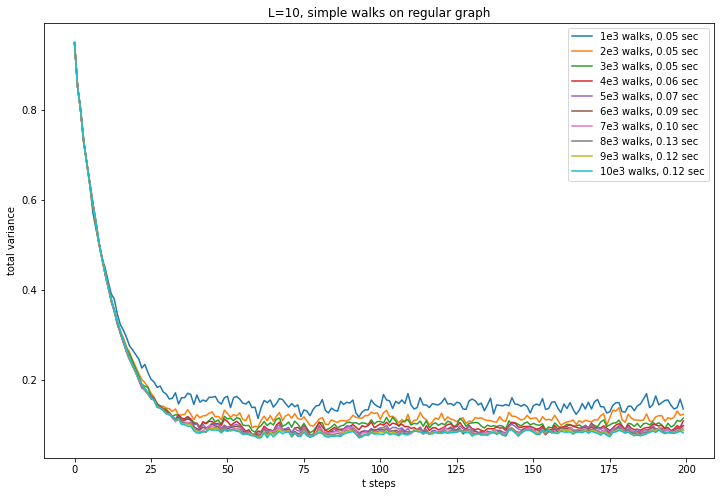

In [10]:
# here we choose the file with L,r, starting node, max_step and max_walks
L=10
r=2
starting=(1,0)
max_steps=200
max_walks=int(10e3)

#uploading the graph
pkl_file = open('Small_world_L={}_r={}/graph.pkl'.format(L,r), 'rb')
G = pickle.load(pkl_file)

#uploading the data
pkl_file = open('Small_world_L={}_r={}/L={}_small_world_steps({})_walks({})_starting={}.pkl'.format(L,r,L,max_steps,max_walks,starting), 'rb')
data = pickle.load(pkl_file)
norm_vector_list_parallel = []
for i in tqdm([1,2,3,4,5,6,7,8,9,10]):
    tic = time()
    norm_vector = get_L1_norm_over_step_count(G, L, data, max_steps=max_steps, max_walks=int(i*1e3))
    toc = time()
    time_i = toc-tic
    norm_vector_list_parallel.append((i, time_i, norm_vector))
# Plot
fig1, ax1 = plt.subplots(figsize=(12,8))
for i, time_i, norm_vector in norm_vector_list_parallel:
    ax1.plot(norm_vector, label="{}e3 walks, {:.2f} sec".format(i, time_i))

ax1.set_title('L={}, simple walks on regular graph'.format(L))
ax1.set_xlabel('t steps')
ax1.set_ylabel('total variance')
ax1.legend()
plt.show()

we can see immediatly that for the range L=[2,..,10] we can safley use just 2000 max_walks to get a good statistic. Moreover we can reduce the max_steps to 25 for these data!
But when we increase L, let's say L=40 (1600 nodes), the things begin to be different
### L=40 and r=2
you need to have the empty folder **Small_world_L=40_r=2**

In [31]:
# here we can decide the number of step, walks and the parameter r
max_steps=200
max_walks=int(30e3) #let's put here max_walks=30e3
r=2

for L in range(40,41): #L=40
    G=small_world_2d(L,r)
    output = open('Small_world_L={}_r={}/graph.pkl'.format(L,r), 'wb')
    pickle.dump(G, output)
    output.close()
    # different starting node (to much to store for L=40 !)
    '''
    for v in G:
        tic = time()
        all_paths=get_path_forG(G, L, r=2, max_steps=max_steps, max_walks=max_walks, start_node=v,
                                random_walk_function=lazy_2d_random_walk_parallel)
        toc = time()
        time_L = toc-tic
        print(toc-tic)
        output = open('Small_world_L={}_r=2/L={}_small_world_steps({})_walks({})_starting={}.pkl'.format(L,L,max_steps,max_walks,v), 'wb')
        pickle.dump(all_paths, output)
        output.close()
    '''
    v=(0,0) #starting node
    tic = time()
    all_paths=get_path_forG(G, L, r=2, max_steps=max_steps, max_walks=max_walks, start_node=v,
                                random_walk_function=lazy_2d_random_walk_parallel)
    toc = time()
    time_L = toc-tic
    print(toc-tic)
    output = open('Small_world_L={}_r={}/L={}_small_world_steps({})_walks({})_starting={}.pkl'.format(L,r,L,max_steps,max_walks,v), 'wb')
    pickle.dump(all_paths, output)
    output.close()

79.68773913383484


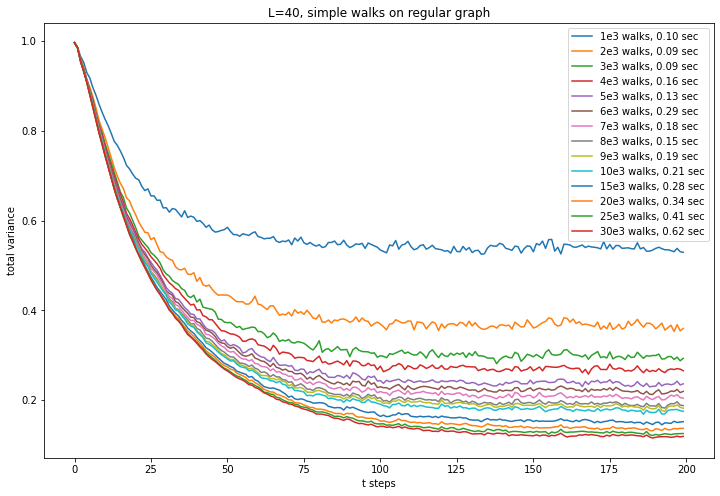

In [32]:
# here we choose the file with L,r, starting node, max_step and max_walks
L=40
r=2
starting=(0,0)
max_steps=200
max_walks=int(30e3)

#uploading the graph
pkl_file = open('Small_world_L={}_r={}/graph.pkl'.format(L,r), 'rb')
G = pickle.load(pkl_file)

#uploading the data
pkl_file = open('Small_world_L={}_r={}/L={}_small_world_steps({})_walks({})_starting={}.pkl'.format(L,r,L,max_steps,max_walks,starting), 'rb')
data = pickle.load(pkl_file)
norm_vector_list_parallel = []
for i in tqdm([1,2,3,4,5,6,7,8,9,10,15,20,25,30]):
    tic = time()
    norm_vector = get_L1_norm_over_step_count(G, L, data, max_steps=max_steps, max_walks=int(i*1e3))
    toc = time()
    time_i = toc-tic
    norm_vector_list_parallel.append((i, time_i, norm_vector))
# Plot
fig1, ax1 = plt.subplots(figsize=(12,8))
for i, time_i, norm_vector in norm_vector_list_parallel:
    ax1.plot(norm_vector, label="{}e3 walks, {:.2f} sec".format(i, time_i))

ax1.set_title('L={}, simple walks on regular graph'.format(L))
ax1.set_xlabel('t steps')
ax1.set_ylabel('total variance')
ax1.legend()
plt.show()

Here we can see that a **good choice for max_walks is 15000**. we can also see that data after max_step=75 are useless (since we want break our analysis at 0.25 total variance).

**Good result:** 

1) for $L<=40$ we can just use max_steps=75, this halves the time of the algortihm

2) for L=[2,..,10] we can just use max_walks=2000

3) for L=40 are at least necessary max_walks=15000

# The mixing time

for L=[2,...,10] and r=2 using the database we can compute the mixing time. Is compute as follow

\begin{equation}
d_i(t)=||P_i(x_t="")-\pi("")||_{TV}={1\over 2}||P_i(x_t="")-\pi("")||_1
\end{equation}
-$P_i(x_t="")$ is the probability to get to some nodes "" after t steps by starting at i node

-$\pi("")$ is the stationary distribution, and therefore the stationary probability to get at "" node

-$d_i(t)$ is the total variance after t steps starting at node i

The mixing time is
\begin{equation}
T_{mix}=\max_i(\min_{t} d_i(t)<0.25)
\end{equation}

Namely the minimum steps needed to get close enough to the stationary distribution (0.25 of total variance) by starting at the worste node

In [48]:
mixing_time=[] # to store mixing time
r=2
max_steps=200
max_walks=int(1e4)
for L in range(2,11):
    tic=time()
    mixing_time_graph=[] # to store the mixing time computed with a given starting node
    #input graph
    input_graph = open('Small_world_L={}_r={}/graph.pkl'.format(L,r), 'rb')
    G = pickle.load(input_graph)
    for starting in G:
        #input path
        path = open('Small_world_L={}_r={}/L={}_small_world_steps({})_walks({})_starting={}.pkl'.format(L,r,L,max_steps,
                                                                                                        max_walks,starting), 'rb')
        data1 = pickle.load(path)
        norm_vector = get_L1_norm_over_step_count(G, L, data1, max_steps=max_steps, max_walks=max_walks)
        path.close()
        for variance in norm_vector:
            # when total variance is less than 0.25 we stop the for cycle and we fill
            # the mixing_time_graph list with the index+1 of the element in norm_vector
            if variance<0.25: 
                mixing_time_graph.append(list(norm_vector).index(variance)+1)
                break
    toc=time()
    print(toc-tic)
    input_graph.close()
    # now we fill the mixing_time list with the max mixing time in mixing_time_graph
    mixing_time.append(max(mixing_time_graph))

0.5739729404449463
1.2436270713806152
2.052908182144165
3.559962034225464
5.144201040267944
7.9541637897491455
12.20496416091919
14.610722064971924
15.75332498550415


## Plot the mixing time and fit

we want to fit the mixing time over the number of nodes $N=L^2$ with the result in the paper
\begin{equation}
T_{mix}=\begin{cases} \Theta(\log (n)) & r>2\\
O(log(n)^4) & r=2\\
n^{\Omega(1)} & r<1
\end{cases}
\end{equation}
In the paper they also said they belive that the correct answer for $r=2$ is $T_{mix}=O(\log(n)^2)$.

So we'll plot for each function

In [58]:
def func2(x, a):
    return a * np.log(x)**2
def func3(x, a):
    return a * np.log(x)**3
def func4(x, a):
    return a * np.log(x)**4

fitted function is f2(n)=  0.8705721953724925 *log(n)^2
fitted function is f3(n)=  0.2119256452978473 *log(n)^3
fitted function is f4(n)=  0.049560872605752024 *log(n)^4


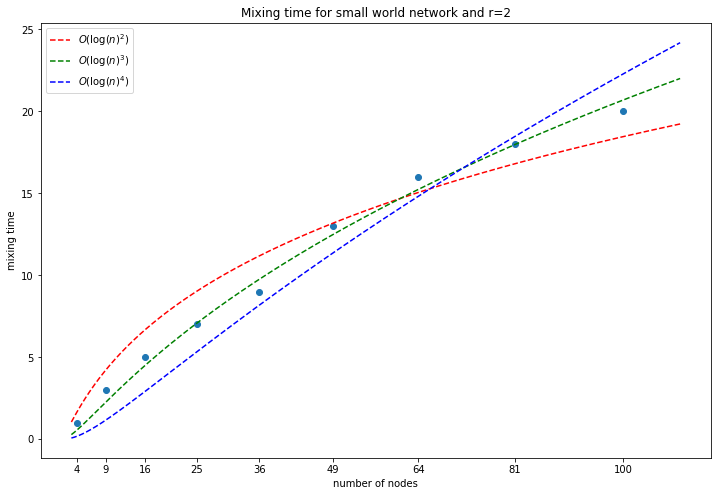

In [68]:
from scipy import optimize

# filling the nodes list
nodes=[]
for L in range(2,11):
    nodes.append(L*L)

# popt is the parameter a
popt2, _ = optimize.curve_fit(func2, nodes, mixing_time)
popt3, _ = optimize.curve_fit(func3, nodes, mixing_time)
popt4, _ = optimize.curve_fit(func4, nodes, mixing_time)
#plot
fig1, ax1 = plt.subplots(figsize=(12,8))
x=np.linspace(3,110,num=1000)
nodes=[]
for L in range(2,11):
    nodes.append(L*L)
ax1.scatter(nodes,mixing_time)
ax1.set_title('Mixing time for small world network and r=2')
ax1.set_xlabel('number of nodes')
ax1.set_ylabel('mixing time')
ax1.set_xticks(nodes)
ax1.plot(x, func2(x, *popt2),'--', color='red', label="$O(\log(n)^2)$")
ax1.plot(x, func3(x, *popt3),'--', color='green', label="$O(\log(n)^3)$")
ax1.plot(x, func4(x, *popt4),'--', color='blue', label="$O(\log(n)^4)$")
print('fitted function is f2(n)= ', popt2[0],'*log(n)^2')
print('fitted function is f3(n)= ', popt3[0],'*log(n)^3')
print('fitted function is f4(n)= ', popt4[0],'*log(n)^4')
ax1.legend()

**Result** for this data it seems to fit better $T_{mix}=O(\log(n)^3)$. Maybe using more number of nodes the result would be different

# What remains to do?

1) it is difficult to perform this analysis for L>10 because we would an need exponentially increasing amount of data, for example for L=10 we need 100 different paths but for L=40 we would need 40^2=1600 different paths. Just for this database we had to wait 2 hours to get the database (but with a clever choice of max_walks and max_steps, for example 2000 and 50, time is significantly reduced)

2) we have seen that for L<10 max_walks=2000 is enough, and for L=40 we need at least max_walks=15000. It would be fine to have an objective method to get the minimum max_walks for each L and also r

3) this analysis must be made also for different r



